#### CSCI-GA 3033-012 Vision meets Machine Learning Assignment 2

Rohan Mahadev - rm5310

Importing Libraries:

In [1]:
import os
import random
import time
import csv

import numpy as np

import torch
import torchvision

from PIL import Image
import cv2


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython import display


from torch.autograd import Variable
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import transforms as T

from engine import train_one_epoch, evaluate
import utils

%load_ext autoreload
%autoreload 2

# from torchvision import transforms
# transform = transforms.Compose([transforms.ToTensor()])  # Convert image to PyTorch Tensor
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [2]:
!ls egohands/DATA_IMAGES/ | head -10 

Image10_100.jpg
Image10_10.jpg
Image10_11.jpg
Image10_12.jpg
Image10_13.jpg
Image10_14.jpg
Image10_15.jpg
Image10_16.jpg
Image10_17.jpg
Image10_18.jpg
ls: write error: Broken pipe


In [19]:
 !ls egohands/DATA_IMAGES/ | wc -l

4800


### Lets visualize some boxes and masks from our dataset. 
(This needs the images from the dataset to be downloaded)
This was just used for me to understand the dataset so its not necessary to run this.

[[398, 686, 93, 34], [673, 425, 332, 295], [612, 267, 132, 101], [476, 262, 126, 104]]


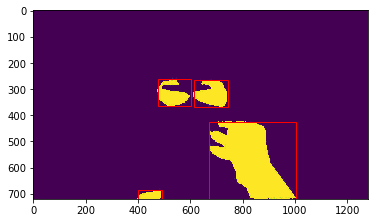

In [3]:
i=2
j=3
mask_path = "./egohands/DATA_MASKS/Mask"+str(i)+"_"+str(j)+".jpg"
box_csv = "./egohands/DATA_BOXES/Box"+str(i)+"_"+str(j)+".csv"
mask = Image.open(mask_path)
mask = np.array(mask)
plt.imshow(mask)
with open(box_csv, 'r') as f:
    reader = csv.reader(f)
    boxes = list(reader)
final_boxes = []
for box in boxes:
    x = int(box[0])
    y = int(box[1])
    width = int(box[2])
    height = int(box[3])
    if width == 0 or height == 0:
        continue
    else:
        final_boxes.append([x,y,width,height])
        plt.gca().add_patch(Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none'))
print(final_boxes) 
plt.show()

### Now, we create the dataset compatible with PyTorch from our directory.

In [4]:
class HandsDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "DATA_IMAGES/"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "DATA_MASKS/"))))
        self.boxes = list(sorted(os.listdir(os.path.join(root, "DATA_BOXES/"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "DATA_IMAGES/", self.imgs[idx])
        mask_path = os.path.join(self.root, "DATA_MASKS/", self.masks[idx])
        box_path = os.path.join(self.root, "DATA_BOXES/", self.boxes[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
#         plt.imshow(mask)
        
        mask = np.array(mask)
        with open(box_path, 'r') as f:
            reader = csv.reader(f)
            boxes = list(reader)    
        final_boxes = []
        for box in boxes:
            x = int(box[0])
            y = int(box[1])
            width = int(box[2])
            height = int(box[3])
            if x <= 0:
                x+=1
            if y <= 0:
                y+=1
            if x+width == 1280:
                x-=1
            if y+height == 720:
                y-=1    
            if width < 20 or height < 20:
                continue
            elif x + width > 1280 or y + height > 720:
                continue
            else:
                final_boxes.append([x,y,x+width,y+height])
        masks = np.zeros((len(final_boxes),720,1280))
        for fb in range(len(final_boxes)):
            box = final_boxes[fb]
            xmin = box[0]
            xmax = box[2]
            ymin = box[1]
            ymax = box[3]
            
            masks[fb][ymin:ymax,xmin:xmax] = mask[ymin:ymax,xmin:xmax]
            
            masks[fb] = np.where(masks[fb] > 0, 1, 0)
                
        boxes = torch.as_tensor(final_boxes, dtype=torch.float32)
        labels = torch.ones((len(final_boxes),), dtype=torch.int64)
        image_id = torch.tensor([idx])
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        iscrowd = torch.zeros((len(final_boxes),), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            try:
                img, target = self.transforms(img, target)
            except:
                print("problem at " + img_path)

        return img, target

    def __len__(self):
        return len(self.imgs)

### Load the pretrained MaskRCNN model and change the final number of classes in it.

In [5]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [1]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [8]:
# our dataset has two classes only - background and hand
num_classes = 2
dataset = HandsDataset('egohands', get_transform(train=True))
dataset_test = HandsDataset('egohands', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=1,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=collate_fn)

### Let's visualize what we get from our pytorch dataset

In [9]:
dataset[0]

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9725, 0.9725, 0.9725],
          [1.0000, 1.0000, 1.0000,  ..., 0.9725, 0.9725, 0.9725],
          [1.0000, 1.0000, 1.0000,  ..., 0.9725, 0.9725, 0.9725],
          ...,
          [0.6549, 0.6549, 0.6549,  ..., 0.6980, 0.6980, 0.6980],
          [0.6549, 0.6549, 0.6549,  ..., 0.6980, 0.6980, 0.6980],
          [0.6549, 0.6549, 0.6549,  ..., 0.6980, 0.6980, 0.6980]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.8667, 0.8667, 0.8667],
          [1.0000, 1.0000, 1.0000,  ..., 0.8667, 0.8667, 0.8667],
          [1.0000, 1.0000, 1.0000,  ..., 0.8667, 0.8667, 0.8667],
          ...,
          [0.5882, 0.5882, 0.5882,  ..., 0.5020, 0.5020, 0.5020],
          [0.5882, 0.5882, 0.5882,  ..., 0.5020, 0.5020, 0.5020],
          [0.5882, 0.5882, 0.5882,  ..., 0.5020, 0.5020, 0.5020]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.5882, 0.5882, 0.5882],
          [1.0000, 1.0000, 1.0000,  ..., 0.5882, 0.5882, 0.5882],
          [1.0000, 1.0000, 1.0000,  ...,

We get masks, boxes, labels along with other information. This is what we need for training.

### Lets see predictions before training model.

In [11]:
# Helper functions to draw predictions:

import torchvision.transforms as T
def plot_mask_rcnn_result(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img.to(device)])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [i for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]  
    return masks, pred_boxes, pred_class

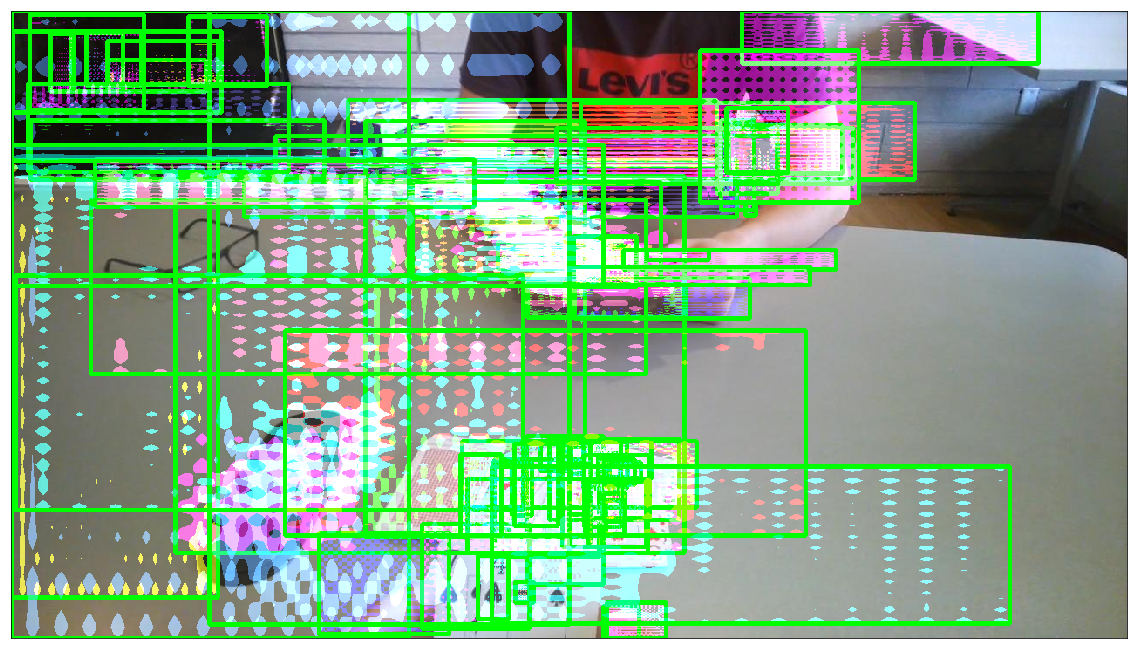

In [14]:
model = get_model_instance_segmentation(num_classes)
model.to(device)
model.eval()
plot_mask_rcnn_result('egohands/DATA_IMAGES/Image9_26.jpg', threshold=0.6)

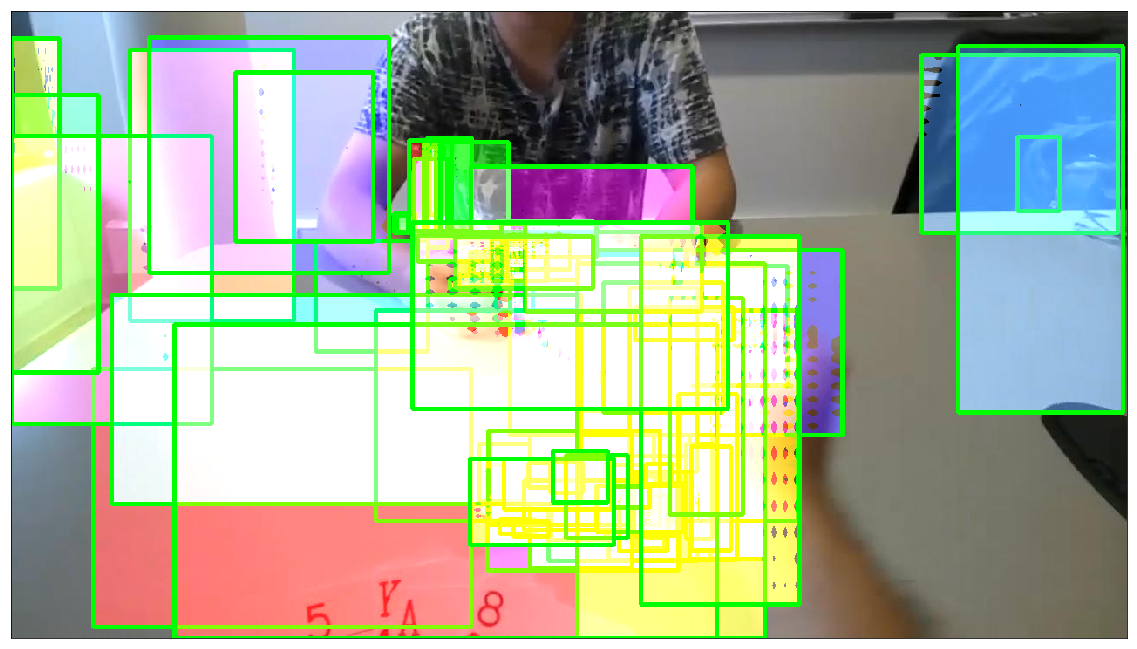

In [21]:
plot_mask_rcnn_result('egohands/DATA_IMAGES/Image10_26.jpg', threshold=0.6)

### These are definitely not good. Lets train the model for 20 epochs now.

In [22]:
model = get_model_instance_segmentation(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
num_epochs = 20
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()

Epoch: [0]  [   0/2375]  eta: 0:42:34  loss_objectness: 0.0309 (0.0309)  loss: 4.6981 (4.6981)  loss_rpn_box_reg: 0.0121 (0.0121)  loss_mask: 3.6880 (3.6880)  loss_box_reg: 0.2721 (0.2721)  loss_classifier: 0.6950 (0.6950)  lr: 0.000010  time: 1.0757  data: 0.3580  max mem: 4701
Epoch: [0]  [  10/2375]  eta: 0:26:14  loss_objectness: 0.0611 (0.0613)  loss: 3.3104 (3.6030)  loss_rpn_box_reg: 0.0195 (0.0201)  loss_mask: 2.5056 (2.7322)  loss_box_reg: 0.1786 (0.1699)  loss_classifier: 0.6288 (0.6195)  lr: 0.000060  time: 0.6656  data: 0.0390  max mem: 4978
some issue here. skipping.
Epoch: [1]  [   0/2375]  eta: 0:37:45  loss_objectness: 0.0631 (0.0631)  loss: 1.2528 (1.2528)  loss_rpn_box_reg: 0.0157 (0.0157)  loss_mask: 0.7181 (0.7181)  loss_box_reg: 0.1618 (0.1618)  loss_classifier: 0.2941 (0.2941)  lr: 0.005000  time: 0.9539  data: 0.3145  max mem: 4978
Epoch: [1]  [  10/2375]  eta: 0:25:39  loss_objectness: 0.1000 (0.1337)  loss: 1.2528 (1.4175)  loss_rpn_box_reg: 0.0263 (0.0313)  lo

Epoch: [4]  [ 140/2375]  eta: 0:24:03  loss_objectness: 0.0055 (0.0139)  loss: 0.5147 (0.6011)  loss_rpn_box_reg: 0.0133 (0.0181)  loss_mask: 0.2775 (0.2932)  loss_box_reg: 0.1187 (0.1482)  loss_classifier: 0.1209 (0.1277)  lr: 0.000500  time: 0.6479  data: 0.0072  max mem: 4978
Epoch: [4]  [ 150/2375]  eta: 0:23:55  loss_objectness: 0.0055 (0.0138)  loss: 0.4923 (0.5951)  loss_rpn_box_reg: 0.0152 (0.0181)  loss_mask: 0.2635 (0.2913)  loss_box_reg: 0.0990 (0.1451)  loss_classifier: 0.1033 (0.1268)  lr: 0.000500  time: 0.6448  data: 0.0072  max mem: 4978
Epoch: [4]  [ 160/2375]  eta: 0:23:48  loss_objectness: 0.0063 (0.0143)  loss: 0.5444 (0.5948)  loss_rpn_box_reg: 0.0178 (0.0182)  loss_mask: 0.2733 (0.2909)  loss_box_reg: 0.1115 (0.1439)  loss_classifier: 0.1079 (0.1275)  lr: 0.000500  time: 0.6387  data: 0.0073  max mem: 4978
Epoch: [4]  [ 170/2375]  eta: 0:23:41  loss_objectness: 0.0079 (0.0140)  loss: 0.5239 (0.5904)  loss_rpn_box_reg: 0.0181 (0.0181)  loss_mask: 0.2735 (0.2895)  l

some issue here. skipping.
Epoch: [5]  [   0/2375]  eta: 0:40:00  loss_objectness: 0.0043 (0.0043)  loss: 0.6026 (0.6026)  loss_rpn_box_reg: 0.0237 (0.0237)  loss_mask: 0.3477 (0.3477)  loss_box_reg: 0.1021 (0.1021)  loss_classifier: 0.1248 (0.1248)  lr: 0.000500  time: 1.0108  data: 0.3478  max mem: 4978
Epoch: [5]  [  10/2375]  eta: 0:26:37  loss_objectness: 0.0031 (0.0051)  loss: 0.4157 (0.4251)  loss_rpn_box_reg: 0.0099 (0.0145)  loss_mask: 0.2121 (0.2314)  loss_box_reg: 0.0735 (0.0813)  loss_classifier: 0.0853 (0.0928)  lr: 0.000500  time: 0.6753  data: 0.0382  max mem: 4978
Epoch: [5]  [  20/2375]  eta: 0:26:05  loss_objectness: 0.0030 (0.0046)  loss: 0.4212 (0.4389)  loss_rpn_box_reg: 0.0099 (0.0134)  loss_mask: 0.2395 (0.2417)  loss_box_reg: 0.0735 (0.0840)  loss_classifier: 0.0853 (0.0953)  lr: 0.000500  time: 0.6477  data: 0.0072  max mem: 4978
Epoch: [5]  [  30/2375]  eta: 0:25:51  loss_objectness: 0.0035 (0.0135)  loss: 0.4729 (0.4818)  loss_rpn_box_reg: 0.0109 (0.0149)  lo

Epoch: [6]  [ 100/2375]  eta: 0:24:33  loss_objectness: 0.0045 (0.0108)  loss: 0.4350 (0.4543)  loss_rpn_box_reg: 0.0125 (0.0133)  loss_mask: 0.2462 (0.2498)  loss_box_reg: 0.0798 (0.0812)  loss_classifier: 0.0975 (0.0993)  lr: 0.000050  time: 0.6497  data: 0.0080  max mem: 4978
Epoch: [6]  [ 110/2375]  eta: 0:24:29  loss_objectness: 0.0056 (0.0109)  loss: 0.3965 (0.4539)  loss_rpn_box_reg: 0.0125 (0.0134)  loss_mask: 0.2359 (0.2487)  loss_box_reg: 0.0759 (0.0813)  loss_classifier: 0.0886 (0.0997)  lr: 0.000050  time: 0.6532  data: 0.0076  max mem: 4978
Epoch: [6]  [ 120/2375]  eta: 0:24:22  loss_objectness: 0.0056 (0.0104)  loss: 0.3924 (0.4541)  loss_rpn_box_reg: 0.0130 (0.0133)  loss_mask: 0.2294 (0.2486)  loss_box_reg: 0.0725 (0.0816)  loss_classifier: 0.0886 (0.1001)  lr: 0.000050  time: 0.6530  data: 0.0072  max mem: 4978
Epoch: [6]  [ 130/2375]  eta: 0:24:14  loss_objectness: 0.0046 (0.0103)  loss: 0.4193 (0.4544)  loss_rpn_box_reg: 0.0147 (0.0136)  loss_mask: 0.2542 (0.2505)  l

Epoch: [7]  [  50/2375]  eta: 0:25:16  loss_objectness: 0.0066 (0.0097)  loss: 0.4513 (0.4533)  loss_rpn_box_reg: 0.0092 (0.0156)  loss_mask: 0.2407 (0.2488)  loss_box_reg: 0.0757 (0.0806)  loss_classifier: 0.0925 (0.0986)  lr: 0.000050  time: 0.6424  data: 0.0076  max mem: 4978
Epoch: [7]  [  60/2375]  eta: 0:25:05  loss_objectness: 0.0050 (0.0091)  loss: 0.4471 (0.4572)  loss_rpn_box_reg: 0.0113 (0.0157)  loss_mask: 0.2439 (0.2510)  loss_box_reg: 0.0770 (0.0820)  loss_classifier: 0.0851 (0.0994)  lr: 0.000050  time: 0.6416  data: 0.0073  max mem: 4978
Epoch: [7]  [  70/2375]  eta: 0:25:01  loss_objectness: 0.0046 (0.0088)  loss: 0.4423 (0.4522)  loss_rpn_box_reg: 0.0120 (0.0154)  loss_mask: 0.2328 (0.2483)  loss_box_reg: 0.0785 (0.0813)  loss_classifier: 0.0833 (0.0984)  lr: 0.000050  time: 0.6492  data: 0.0072  max mem: 4978
Epoch: [7]  [  80/2375]  eta: 0:24:52  loss_objectness: 0.0032 (0.0089)  loss: 0.4330 (0.4519)  loss_rpn_box_reg: 0.0118 (0.0153)  loss_mask: 0.2275 (0.2463)  l

Epoch: [8]  [  30/2375]  eta: 0:25:47  loss_objectness: 0.0053 (0.0071)  loss: 0.4228 (0.4272)  loss_rpn_box_reg: 0.0108 (0.0122)  loss_mask: 0.2282 (0.2392)  loss_box_reg: 0.0738 (0.0757)  loss_classifier: 0.0855 (0.0930)  lr: 0.000050  time: 0.6560  data: 0.0077  max mem: 4978
Epoch: [8]  [  40/2375]  eta: 0:25:29  loss_objectness: 0.0033 (0.0061)  loss: 0.4074 (0.4240)  loss_rpn_box_reg: 0.0103 (0.0115)  loss_mask: 0.2341 (0.2425)  loss_box_reg: 0.0717 (0.0729)  loss_classifier: 0.0775 (0.0911)  lr: 0.000050  time: 0.6516  data: 0.0075  max mem: 4978
Epoch: [8]  [  50/2375]  eta: 0:25:15  loss_objectness: 0.0021 (0.0074)  loss: 0.4006 (0.4250)  loss_rpn_box_reg: 0.0099 (0.0115)  loss_mask: 0.2277 (0.2410)  loss_box_reg: 0.0671 (0.0732)  loss_classifier: 0.0729 (0.0919)  lr: 0.000050  time: 0.6392  data: 0.0072  max mem: 4978
Epoch: [8]  [  60/2375]  eta: 0:25:04  loss_objectness: 0.0040 (0.0082)  loss: 0.3917 (0.4253)  loss_rpn_box_reg: 0.0091 (0.0121)  loss_mask: 0.2275 (0.2406)  l

Epoch: [10]  [ 120/2375]  eta: 0:24:33  loss_objectness: 0.0037 (0.0075)  loss: 0.4198 (0.4370)  loss_rpn_box_reg: 0.0122 (0.0143)  loss_mask: 0.2214 (0.2400)  loss_box_reg: 0.0714 (0.0788)  loss_classifier: 0.0820 (0.0964)  lr: 0.000005  time: 0.6479  data: 0.0073  max mem: 4978
Epoch: [10]  [ 130/2375]  eta: 0:24:26  loss_objectness: 0.0037 (0.0074)  loss: 0.3836 (0.4338)  loss_rpn_box_reg: 0.0112 (0.0140)  loss_mask: 0.2230 (0.2391)  loss_box_reg: 0.0835 (0.0780)  loss_classifier: 0.0820 (0.0953)  lr: 0.000005  time: 0.6514  data: 0.0072  max mem: 4978
some issue here. skipping.
Epoch: [11]  [   0/2375]  eta: 0:36:15  loss_objectness: 0.0041 (0.0041)  loss: 0.4713 (0.4713)  loss_rpn_box_reg: 0.0388 (0.0388)  loss_mask: 0.2826 (0.2826)  loss_box_reg: 0.0929 (0.0929)  loss_classifier: 0.0529 (0.0529)  lr: 0.000005  time: 0.9158  data: 0.2662  max mem: 4978
Epoch: [11]  [  10/2375]  eta: 0:26:17  loss_objectness: 0.0031 (0.0064)  loss: 0.4713 (0.4480)  loss_rpn_box_reg: 0.0108 (0.0146)

Epoch: [14]  [  10/2375]  eta: 0:26:13  loss_objectness: 0.0063 (0.0086)  loss: 0.4569 (0.4572)  loss_rpn_box_reg: 0.0120 (0.0118)  loss_mask: 0.2541 (0.2459)  loss_box_reg: 0.0835 (0.0812)  loss_classifier: 0.1076 (0.1098)  lr: 0.000001  time: 0.6651  data: 0.0263  max mem: 4978
Epoch: [14]  [  20/2375]  eta: 0:25:44  loss_objectness: 0.0052 (0.0082)  loss: 0.4437 (0.4456)  loss_rpn_box_reg: 0.0102 (0.0107)  loss_mask: 0.2349 (0.2372)  loss_box_reg: 0.0815 (0.0821)  loss_classifier: 0.1091 (0.1073)  lr: 0.000001  time: 0.6452  data: 0.0073  max mem: 4978
Epoch: [14]  [  30/2375]  eta: 0:25:35  loss_objectness: 0.0052 (0.0120)  loss: 0.4042 (0.4428)  loss_rpn_box_reg: 0.0084 (0.0119)  loss_mask: 0.2219 (0.2376)  loss_box_reg: 0.0751 (0.0788)  loss_classifier: 0.1054 (0.1026)  lr: 0.000001  time: 0.6493  data: 0.0073  max mem: 4978
Epoch: [14]  [  40/2375]  eta: 0:25:23  loss_objectness: 0.0046 (0.0109)  loss: 0.4047 (0.4465)  loss_rpn_box_reg: 0.0128 (0.0141)  loss_mask: 0.2245 (0.2400

Epoch: [15]  [ 120/2375]  eta: 0:24:23  loss_objectness: 0.0069 (0.0084)  loss: 0.4619 (0.4382)  loss_rpn_box_reg: 0.0113 (0.0134)  loss_mask: 0.2506 (0.2421)  loss_box_reg: 0.0862 (0.0783)  loss_classifier: 0.0959 (0.0961)  lr: 0.000000  time: 0.6513  data: 0.0075  max mem: 4978
Epoch: [15]  [ 130/2375]  eta: 0:24:16  loss_objectness: 0.0069 (0.0084)  loss: 0.4619 (0.4381)  loss_rpn_box_reg: 0.0124 (0.0133)  loss_mask: 0.2427 (0.2418)  loss_box_reg: 0.0799 (0.0780)  loss_classifier: 0.1055 (0.0965)  lr: 0.000000  time: 0.6439  data: 0.0076  max mem: 4978
Epoch: [15]  [ 140/2375]  eta: 0:24:08  loss_objectness: 0.0053 (0.0088)  loss: 0.4520 (0.4432)  loss_rpn_box_reg: 0.0131 (0.0138)  loss_mask: 0.2300 (0.2427)  loss_box_reg: 0.0790 (0.0795)  loss_classifier: 0.1008 (0.0984)  lr: 0.000000  time: 0.6413  data: 0.0075  max mem: 4978
Epoch: [15]  [ 150/2375]  eta: 0:24:00  loss_objectness: 0.0065 (0.0087)  loss: 0.4404 (0.4420)  loss_rpn_box_reg: 0.0128 (0.0136)  loss_mask: 0.2440 (0.2428

Epoch: [16]  [ 250/2375]  eta: 0:22:57  loss_objectness: 0.0067 (0.0096)  loss: 0.5148 (0.4513)  loss_rpn_box_reg: 0.0135 (0.0148)  loss_mask: 0.2521 (0.2461)  loss_box_reg: 0.0952 (0.0825)  loss_classifier: 0.1030 (0.0983)  lr: 0.000000  time: 0.6494  data: 0.0072  max mem: 4978
Epoch: [16]  [ 260/2375]  eta: 0:22:50  loss_objectness: 0.0085 (0.0096)  loss: 0.4032 (0.4512)  loss_rpn_box_reg: 0.0131 (0.0147)  loss_mask: 0.2153 (0.2460)  loss_box_reg: 0.0630 (0.0825)  loss_classifier: 0.0868 (0.0985)  lr: 0.000000  time: 0.6413  data: 0.0074  max mem: 4978
Epoch: [16]  [ 270/2375]  eta: 0:22:43  loss_objectness: 0.0068 (0.0097)  loss: 0.4052 (0.4514)  loss_rpn_box_reg: 0.0108 (0.0146)  loss_mask: 0.2260 (0.2461)  loss_box_reg: 0.0630 (0.0822)  loss_classifier: 0.0868 (0.0988)  lr: 0.000000  time: 0.6461  data: 0.0078  max mem: 4978
Epoch: [16]  [ 280/2375]  eta: 0:22:38  loss_objectness: 0.0059 (0.0096)  loss: 0.4335 (0.4505)  loss_rpn_box_reg: 0.0108 (0.0145)  loss_mask: 0.2270 (0.2456

Epoch: [17]  [ 110/2375]  eta: 0:24:25  loss_objectness: 0.0046 (0.0078)  loss: 0.4042 (0.4303)  loss_rpn_box_reg: 0.0120 (0.0129)  loss_mask: 0.2251 (0.2396)  loss_box_reg: 0.0733 (0.0762)  loss_classifier: 0.0968 (0.0938)  lr: 0.000000  time: 0.6406  data: 0.0071  max mem: 4978
Epoch: [17]  [ 120/2375]  eta: 0:24:19  loss_objectness: 0.0044 (0.0077)  loss: 0.4122 (0.4281)  loss_rpn_box_reg: 0.0121 (0.0128)  loss_mask: 0.2301 (0.2386)  loss_box_reg: 0.0733 (0.0755)  loss_classifier: 0.0949 (0.0935)  lr: 0.000000  time: 0.6456  data: 0.0071  max mem: 4978
some issue here. skipping.
Epoch: [18]  [   0/2375]  eta: 0:37:11  loss_objectness: 0.0057 (0.0057)  loss: 0.5582 (0.5582)  loss_rpn_box_reg: 0.0123 (0.0123)  loss_mask: 0.3189 (0.3189)  loss_box_reg: 0.0758 (0.0758)  loss_classifier: 0.1456 (0.1456)  lr: 0.000000  time: 0.9394  data: 0.2888  max mem: 4978
Epoch: [18]  [  10/2375]  eta: 0:26:26  loss_objectness: 0.0042 (0.0089)  loss: 0.4385 (0.4527)  loss_rpn_box_reg: 0.0123 (0.0125)

### Test on some images after training:

In [24]:
num_classes=2
state_dict = torch.load('finetuned_19.pth')
model.load_state_dict(state_dict)
# move model to the right device
model.to(device)
model.eval();

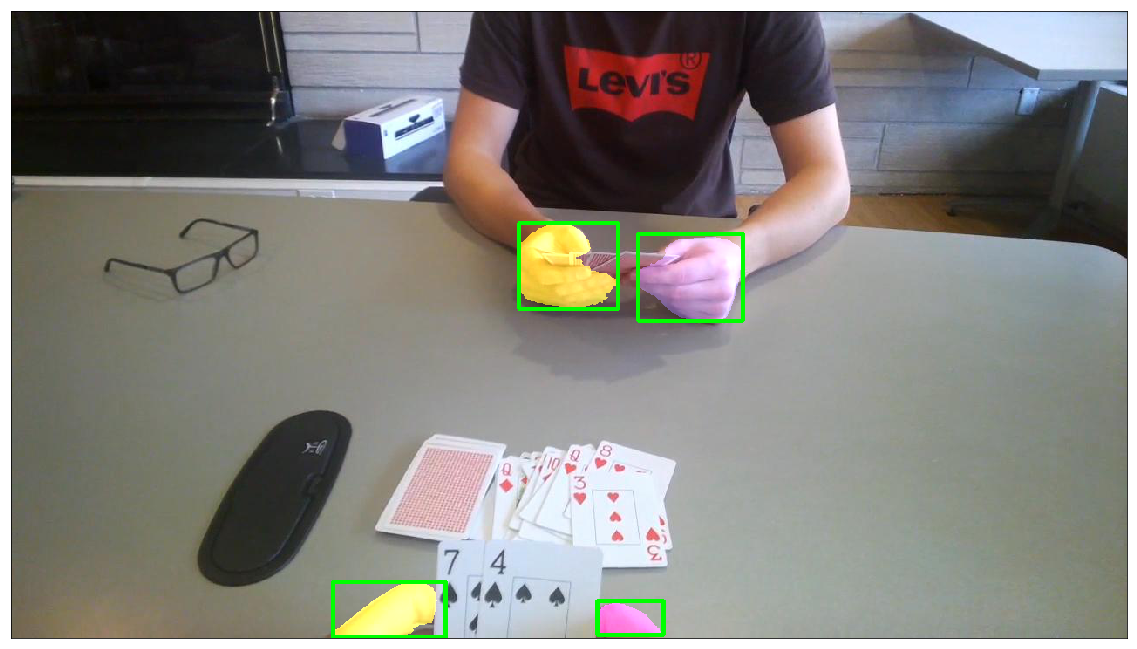

In [25]:
plot_mask_rcnn_result('egohands/DATA_IMAGES/Image9_26.jpg', threshold=0.9)

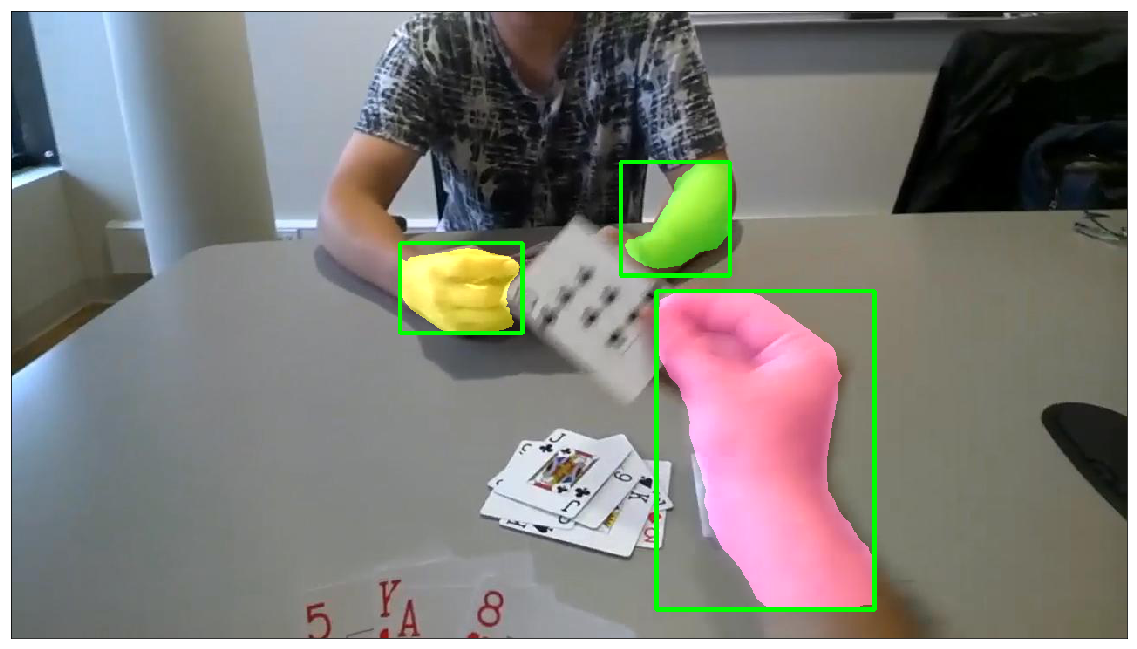

In [26]:
plot_mask_rcnn_result('egohands/DATA_IMAGES/Image10_26.jpg', threshold=0.6)

Looks good, now let's test on some images not in the dataset

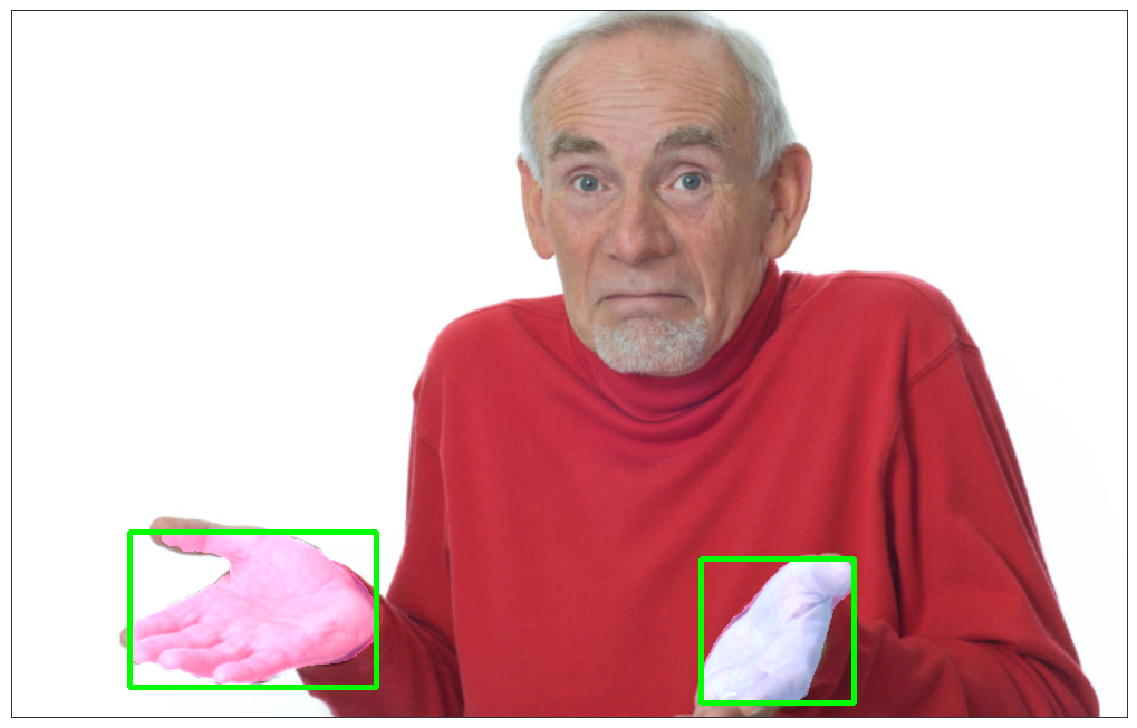

In [30]:
plot_mask_rcnn_result('test_images/1.jpg', threshold=0.9)

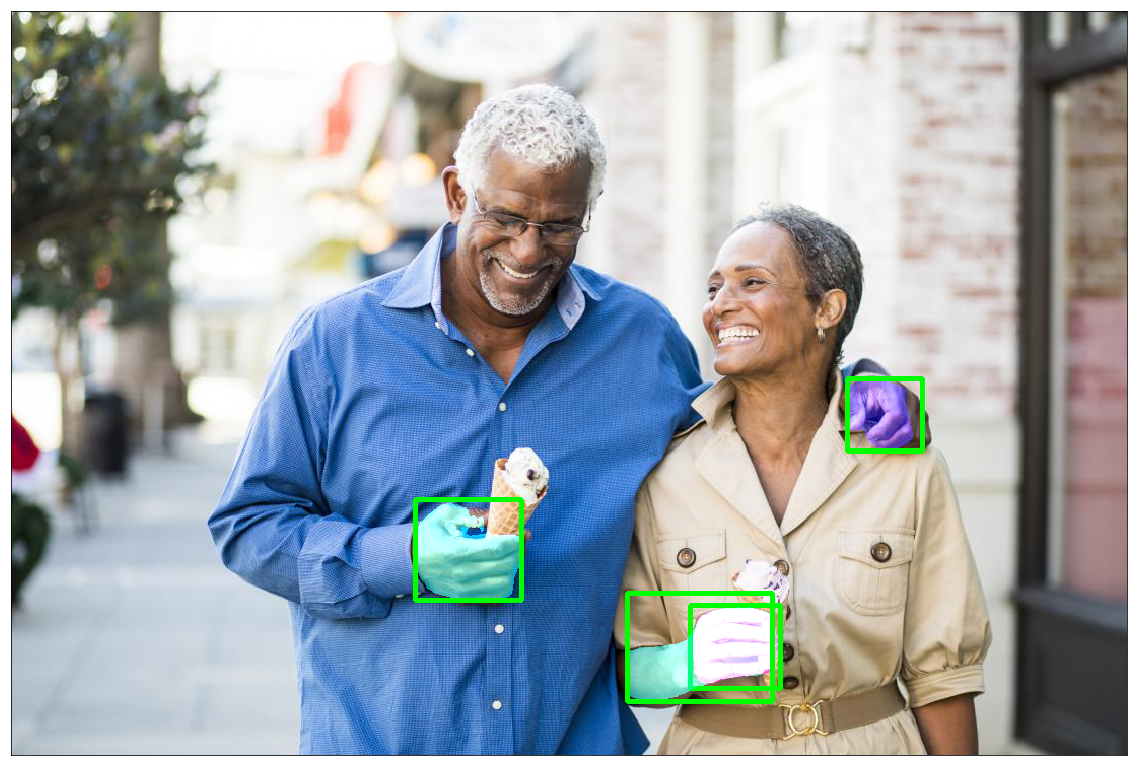

In [36]:
plot_mask_rcnn_result('test_images/2.jpg', threshold=0.7)

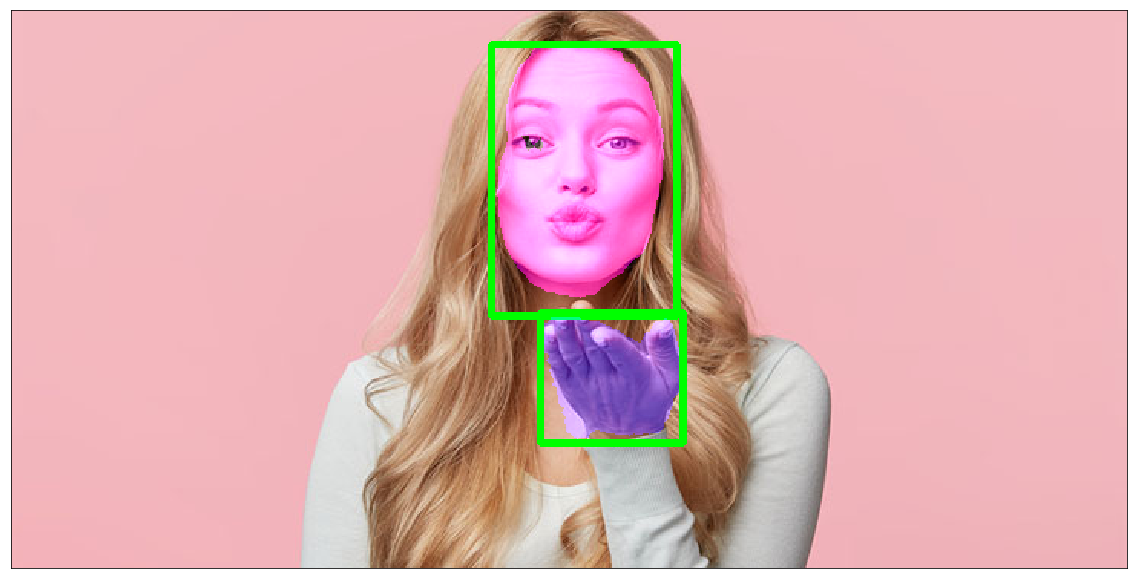

In [40]:
plot_mask_rcnn_result('test_images/3.jpg', threshold=0.8)

Sometimes it detects faces as hands, but this is probably because there are no faces in the training set, hence by adding more pictures with faces in the training set would mitigate this problem.

The different hyperparameters that were tested during training were changing the optimizer from SGD to Adam. Adam gave better performances.

Then the initial learning rate was set to 0.01, which was then reduced to 0.005.

With these, I got good enough results and hence these are the final parameters I trained my model with.